In [4]:
import interpolation as interp
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
terms = tf.constant([1, 2, 3, 4, 5],
                 dtype = np.float32)
rate = tf.constant([0.01, 0.012, 0.015, 0.015, 0.017],
                   dtype = np.float32)

In [7]:
grids = tf.constant([0, 1, 2, 3, 4, 5], dtype = np.float32)
dfs = tf.Variable([0.993, 0.98,0.97,0.95, 0.94], dtype = tf.float32)
df0 = tf.constant([1], dtype = tf.float32)
dfs = tf.concat([df0, dfs], axis = 0)

In [25]:
# curve = interp.log_linear
curve = interp.monotone_convex
rate_calc = -tf.log(curve(terms, grids, dfs)) / terms
loss = tf.reduce_mean(tf.square(rate - rate_calc))
optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)

In [26]:
# A list of `sum(d rate_calc/d dfs)` for each df in `dfs`.
jacobian = []
for i in range(rate_calc.shape[0]):
    jacobian.append(tf.gradients(rate_calc[i], dfs))

In [27]:
%%time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(150):
        sess.run(optimizer)

    dfs_calib = sess.run(dfs)
    print('df@regular :', dfs_calib)
    print('rate calc :', sess.run(rate_calc))
    
    jacobian_value = sess.run(jacobian)
    print('jacobian :', jacobian_value)

df@regular : [1.         0.9897802  0.97612125 0.95567876 0.94185776 0.9182773 ]
rate calc : [0.01027239 0.01208424 0.01511115 0.01497525 0.01705117]
jacobian : [[array([ 0.       , -1.0103253,  0.       ,  0.       ,  0.       ,
        0.       ], dtype=float32)], [array([ 0.        ,  0.        , -0.51223147,  0.        ,  0.        ,
        0.        ], dtype=float32)], [array([ 0.        ,  0.        ,  0.        , -0.34879225,  0.        ,
        0.        ], dtype=float32)], [array([ 0.        ,  0.        ,  0.        ,  0.        , -0.26543286,
        0.        ], dtype=float32)], [array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -1.4901161e-08, -2.1779914e-01], dtype=float32)]]
CPU times: user 7.91 s, sys: 207 ms, total: 8.12 s
Wall time: 7.89 s


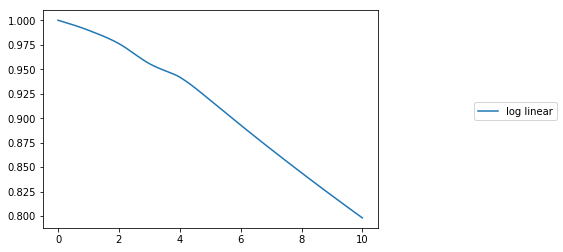

In [29]:
ts = np.arange(0, 10, 1. / 365., dtype = np.float32)

df = curve(ts, grids, dfs_calib)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    df = sess.run(df)
#        print(sess.run(df))
    plt.plot(ts, df, label = 'log linear')
    plt.legend(bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

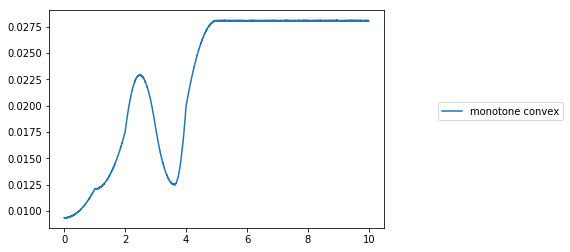

In [14]:
fwd = -np.log(df[1:] / df[:-1]) / (ts[1:] - ts[:-1])
plt.plot(ts[:-1], fwd, label = 'monotone convex')
plt.legend(bbox_to_anchor=(1.05, 0.5, 0.5, .100))
plt.show()